In [1]:
import pandas as pd
from pandas_datareader import data, wb
import datetime

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
start = pd.to_datetime('2015-09-24')
end = pd.to_datetime('2020-09-24')
data_df = data.DataReader('TSLA','yahoo',start,end)
data_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-09-24,52.689999,51.242001,51.905998,52.624001,17241000.0,52.624001
2015-09-25,53.382000,51.230000,53.321999,51.382000,18867000.0,51.382000
2015-09-28,51.958000,49.321999,51.470001,49.686001,24505500.0,49.686001
2015-09-29,50.945999,49.091999,50.091999,49.330002,18516000.0,49.330002
2015-09-30,50.480000,48.467999,50.400002,49.680000,24648000.0,49.680000
...,...,...,...,...,...,...
2020-09-18,451.000000,428.799988,447.940002,442.149994,86406800.0,442.149994
2020-09-21,455.679993,407.070007,453.130005,449.390015,109476800.0,449.390015
2020-09-22,437.760010,417.600006,429.600006,424.230011,79580800.0,424.230011


In [3]:
df1=data_df.reset_index()['Close']
df1

0        52.624001
1        51.382000
2        49.686001
3        49.330002
4        49.680000
           ...    
1255    442.149994
1256    449.390015
1257    424.230011
1258    380.359985
1259    387.790009
Name: Close, Length: 1260, dtype: float64

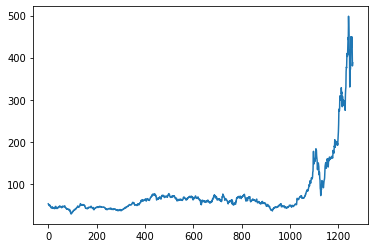

In [4]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
import numpy as np
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
df1

array([[0.0508746 ],
       [0.04822972],
       [0.04461803],
       ...,
       [0.84222273],
       [0.74879996],
       [0.76462246]])

In [7]:
training_size=int(len(df1)*0.80)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [8]:
training_size,test_size

(1008, 252)

In [10]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [11]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [12]:
print(X_train.shape), print(y_train.shape)

(907, 100)
(907,)


(None, None)

In [13]:
print(X_test.shape), print(ytest.shape)

(151, 100)
(151,)


(None, None)

In [14]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [16]:
model=Sequential()
model.add(LSTM(60,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(60,return_sequences=True))
model.add(LSTM(60))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 60)           14880     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 60)           29040     
_________________________________________________________________
lstm_2 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dense (Dense)                (None, 1)                 61        
Total params: 73,021
Trainable params: 73,021
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 1s 78ms/step - loss: 0.0010 - val_loss: 0.1160
Epoch 2/100
15/15 [==============================] - 0s 17ms/step - loss: 2.7980e-04 - val_loss: 0.0567
Epoch 3/100
15/15 [==============================] - 0s 15ms/step - loss: 1.1185e-04 - val_loss: 0.0137
Epoch 4/100
15/15 [==============================] - 0s 15ms/step - loss: 8.7264e-05 - val_loss: 0.0259
Epoch 5/100
15/15 [==============================] - 0s 15ms/step - loss: 8.4351e-05 - val_loss: 0.0164
Epoch 6/100
15/15 [==============================] - 0s 15ms/step - loss: 7.9954e-05 - val_loss: 0.0195
Epoch 7/100
15/15 [==============================] - 0s 15ms/step - loss: 7.9101e-05 - val_loss: 0.0185
Epoch 8/100
15/15 [==============================] - 0s 15ms/step - loss: 8.0605e-05 - val_loss: 0.0158
Epoch 9/100
15/15 [==============================] - 0s 15ms/step - loss: 7.4214e-05 - val_loss: 0.0172
Epoch 10/100
15/15 [==============================] - 0s 15ms/step -

In [19]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)


In [20]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [21]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

57.10988176727386

In [22]:
math.sqrt(mean_squared_error(ytest,test_predict))

224.20645058496027

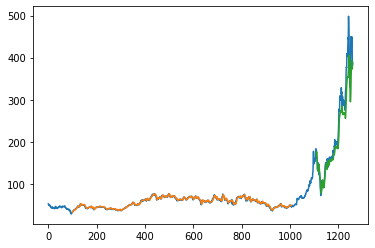

In [23]:
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [24]:
len(test_data)

252

In [25]:
x_input=test_data[152:].reshape(1,-1)
x_input.shape

(1, 100)

In [26]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.2659959983721903,
 0.2721163003601296,
 0.2710344732708948,
 0.2878067086967685,
 0.2843440691544311,
 0.28354338128293155,
 0.2756853906742308,
 0.2809538590291455,
 0.27918208406541084,
 0.28534069663329814,
 0.28294711398687955,
 0.2861627006544549,
 0.29129063189463256,
 0.2867249141016643,
 0.28757245850945307,
 0.2881516988810837,
 0.2820101132376177,
 0.29444233510149737,
 0.32131706071141214,
 0.3142725606616575,
 0.3148688279577095,
 0.3069554998446395,
 0.31601879523876014,
 0.3433875616099378,
 0.3394479407248894,
 0.3753859617289248,
 0.3531493508348995,
 0.337152295388024,
 0.36084123144810065,
 0.3571060311384998,
 0.36122030797538907,
 0.36640360921406656,
 0.3651003021308323,
 0.36229784583938796,
 0.36547512192701537,
 0.34804273574437916,
 0.35874578244970806,
 0.34756997863864286,
 0.3686992220568014,
 0.3987086564432902,
 0.4156682530260596,
 0.45358675879451305,
 0.522975570071848,
 0.5307610987693665,
 0.5205478685883257,
 0.5326436137301008,
 0.596687270504364

In [27]:
from numpy import array
lst_output=[]
n_steps=100
i=0
while(i<11):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day Prediction {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    




1 day Prediction [[0.58560824]]
2 day Prediction [[0.52537066]]
3 day Prediction [[0.470274]]
4 day Prediction [[0.42486656]]
5 day Prediction [[0.39037806]]
6 day Prediction [[0.36613104]]
7 day Prediction [[0.35045773]]
8 day Prediction [[0.34124902]]
9 day Prediction [[0.33632126]]
10 day Prediction [[0.33367905]]


In [28]:
print(lst_output)
print(len(lst_output))

[[0.6420430541038513], [0.5856082439422607], [0.5253706574440002], [0.4702740013599396], [0.42486655712127686], [0.39037805795669556], [0.3661310374736786], [0.35045772790908813], [0.341249018907547], [0.33632126450538635], [0.33367905020713806]]
11


In [29]:
import itertools
b = lst_output
c =list(itertools.chain.from_iterable(b))
print(c)


[0.6420430541038513, 0.5856082439422607, 0.5253706574440002, 0.4702740013599396, 0.42486655712127686, 0.39037805795669556, 0.3661310374736786, 0.35045772790908813, 0.341249018907547, 0.33632126450538635, 0.33367905020713806]


In [33]:
e = scaler.inverse_transform(b)
e

array([[330.22843404],
       [303.72743682],
       [275.44070904],
       [249.56809025],
       [228.24538977],
       [212.05007313],
       [200.66401157],
       [193.3040447 ],
       [188.9797638 ],
       [186.66575928],
       [185.42501242]])